In [16]:
import pyNUISANCE as pn
pn.hpd.disable_debug()
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata",
    "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/CC0Pi_CO_TKI_2024/submission-999999/submission.yaml"})
ana = hepdata_rec.analysis("cross_section_c")

In [2]:
probe_part, probe_flux_count = ana.get_probe_flux(False)
_, probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count", probe_flux_count,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count_density", probe_flux_count_density,False,"UPDATE")

print(probe_part)
[ str(tgt) for tgt in ana.get_target() ]

14


['{ A = 12, Z = 6, weight_by_mass = 1 }']

In [3]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.hepmc3.gz ]; then
    neut-quickstart -t C -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 200000 \
                -o events_for_t2k_CC0Pi_CO_TKI.hepmc3.gz
fi

In [17]:
neut_events = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.hepmc3.gz")
if not neut_events:
    print("Failed to read file")

comparison = ana.process(neut_events)

C12 lhood: 68.5552256868861 for 17 bins.


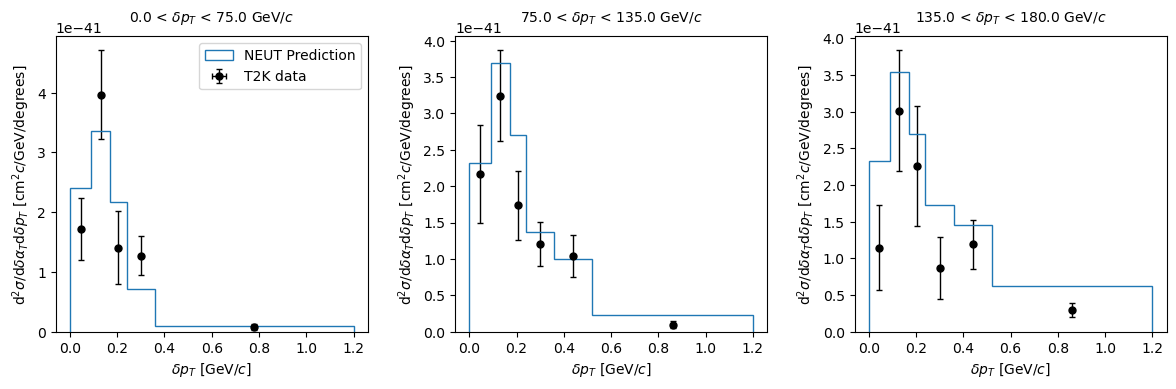

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison.data[0].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison.data[0].project(0).binning.bins)

# should be able to retrieve these from ana
x_proj_prettyname = r"$\delta{}p_{T}$"
x_proj_unit = r"$\mathrm{GeV}/c$"

for i in range(len(d_x_bin_centers)):
    d_slice = comparison.data[0].slice(0,d_x_bin_centers[i])
    p_slice = comparison.predictions[0].slice(0,d_x_bin_centers[i])

    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", plot_axis=axes[i], label="NEUT Prediction")

    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

print(f"C12 lhood: {comparison.likelihood()} for {len(comparison.data[0].binning.bins)} bins.")

fig.tight_layout()
fig.show()